<a href="https://colab.research.google.com/github/cysorianoc/3D-Gaussian-Splatting-Colab-on-the-fly/blob/main/COLAB_gaussian_splatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# On-the-fly Reconstruction for Large-Scale Novel View Synthesis

This notebook demonstrates a practical trial of **Gaussian splatting-based novel view synthesis** using the [On-the-fly Reconstruction](https://doi.org/10.1145/3609952) approach by Meuleman et al. (2025) [@meuleman2025onthefly]. The method reconstructs 3D scenes directly from unposed images and performs fast novel view synthesis without requiring pre-aligned datasets.  

We run experiments using a **Google Colab T4 GPU**, which allows rapid prototyping and lightweight testing of large-scale scenes. This notebook combines **explanatory markdown, Python code, and comments** to provide a didactic workflow suitable for learning, experimentation, and reproducible results.  

Key goals:
- Demonstrate the workflow of Gaussian splatting-based reconstruction.
- Explore configuration options for fast training on limited GPU memory.
- Visualize point clouds and rendered novel views directly in Colab.


## Step 1: Check Environment and GPU

Before starting, we verify the Python version and available GPU to ensure compatibility and sufficient resources. This is especially important when running large-scale novel view synthesis on Colab T4 GPUs.


In [1]:
!nvidia-smi
!python -V


Thu Aug 14 12:17:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Step 2: Setup Repository

We start with a fresh environment to avoid conflicts.  
The repository is cloned along with its submodules to ensure all dependencies are included.  
Finally, we navigate into the project directory and do a quick sanity check by displaying the latest commit and listing files.


In [2]:
# Fresh start (optional)
%cd /content
!rm -rf on-the-fly-nvs

# Clone the repository and its submodules
!git clone --recursive https://github.com/graphdeco-inria/on-the-fly-nvs.git

# Navigate into the project directory
%cd on-the-fly-nvs

# Show commit and files (quick sanity check)
!git log --oneline -n 1
!ls -la


/content
Cloning into 'on-the-fly-nvs'...
remote: Enumerating objects: 808, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 808 (delta 22), reused 14 (delta 13), pack-reused 773 (from 1)
Receiving objects: 100% (808/808), 5.20 MiB | 33.06 MiB/s, done.
Resolving deltas: 100% (259/259), done.
Submodule 'submodules/Depth-Anything-V2' (https://github.com/DepthAnything/Depth-Anything-V2.git) registered for path 'submodules/Depth-Anything-V2'
Submodule 'submodules/fused-ssim' (https://github.com/rahul-goel/fused-ssim) registered for path 'submodules/fused-ssim'
Submodule 'submodules/graphdecoviewer' (https://github.com/graphdeco-inria/graphdecoviewer.git) registered for path 'submodules/graphdecoviewer'
Cloning into '/content/on-the-fly-nvs/submodules/Depth-Anything-V2'...
remote: Enumerating objects: 142, done.        
remote: Total 142 (delta 0), reused 0 (delta 0), pack-reused 142 (from 1)        
Receiving objects: 100% (

## Step 3: Clean Python Environment

Before installing dependencies, we remove old versions of PyTorch, CuPy, and xformers that could cause ABI mismatches.  
We also upgrade the pip stack and restore the `jedi` package required by Colab's IPython environment.


In [ ]:
# Colab is ephemeral, but it's still good to remove preinstalled conflicting wheels
#!pip -q uninstall -y torch torchvision torchaudio xformers cupy-cuda11x cupy-cuda12x cupy || true
#!pip -q install -U pip wheel setuptools


In [3]:
# Remove old torch/cupy/xformers that may cause ABI mismatch
!pip uninstall -y torch torchvision torchaudio xformers cupy-cuda11x cupy-cuda12x cupy || true

# Upgrade pip stack
!pip install -U pip wheel setuptools

# Restore IPython deps Colab expects
!pip install jedi


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: cupy-cuda12x 13.3.0
Uninstalling cupy-cuda12x-13.3.0:
  Successfully uninstalled cupy-cuda12x-13.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.3 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.0 MB/s  0:00:00


## Step 4: Install Compatible PyTorch and GPU Libraries

This step automatically detects the CUDA runtime installed on your Colab GPU and installs a matching version of PyTorch, TorchVision, xformers (optional), and CuPy.  

Key points for users:
- The script reads the CUDA version from `nvidia-smi`.
- Based on the CUDA version, it selects the correct PyTorch wheel (`cu118`, `cu124`, `cu128`).
- `xformers` is optional; if no compatible version exists, the script continues without error.
- CuPy is installed to match the detected CUDA family.
- This ensures there are no ABI mismatches between PyTorch, CuPy, and the GPU driver.

In [4]:
%%bash
# Detect CUDA runtime version from nvidia-smi
CUDA_VER=$(nvidia-smi | grep "CUDA Version" | awk '{print $NF}' | cut -d'.' -f1,2)

# Map CUDA runtime to PyTorch wheel tag
if [[ "$CUDA_VER" == "11.8" ]]; then
    TORCH_CUDA="cu118"
elif [[ "$CUDA_VER" == "12.4" ]]; then
    TORCH_CUDA="cu124"
elif [[ "$CUDA_VER" == "12.8" ]]; then
    TORCH_CUDA="cu128"
else
    echo "⚠️ Unrecognized CUDA version ($CUDA_VER), defaulting to cu124"
    TORCH_CUDA="cu124"
fi

echo "➡️ Installing PyTorch for $TORCH_CUDA"

# Install PyTorch & TorchVision from official matching wheel channel
pip install --no-cache-dir --index-url https://download.pytorch.org/whl/$TORCH_CUDA torch torchvision

# Try installing xformers (optional, skip if unavailable)
pip install --no-cache-dir --index-url https://download.pytorch.org/whl/$TORCH_CUDA xformers || \
echo "⚠️ xformers not available for this CUDA/Torch combo, skipping."

# Install CuPy matching CUDA family
if [[ "$TORCH_CUDA" == "cu118" ]]; then
    pip install --no-cache-dir cupy-cuda11x
else
    pip install --no-cache-dir cupy-cuda12x
fi


⚠️ Unrecognized CUDA version (|), defaulting to cu124
➡️ Installing PyTorch for cu124
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 345.6 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 552.2 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 364.2 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 262.7 MB/s  0:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 399.4 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 56.7 MB/s  0:00:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 197.6 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 425.1 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 116.7 MB/s  0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 352.1 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires cupy-cuda12x>=12.0.0, which is not installed.
cuml-cu12 25.6.0 requires cupy-cuda12x>=12.0.0, which is not installed.
dask-cudf-cu12 25.6.0 requires cupy-cuda12x>=12.0.0, which is not installed.


## Step 5: Verify PyTorch and GPU Setup

After installing PyTorch and GPU libraries, it is important to check that:
- PyTorch is installed correctly.
- CUDA is available and can be used by PyTorch.
- The correct GPU device is detected.
- Your Python version is compatible with the environment.

This step prints the PyTorch version, CUDA availability, number of GPUs, device name, and Python version for verification.


In [5]:
import torch, platform
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")
print("Python:", platform.python_version())


Torch version: 2.6.0+cu124
CUDA available: True
CUDA device count: 1
Device: Tesla T4
Python: 3.11.13


## Step 6: Install Project Dependencies (may take 10-15 minutes)

Now that the environment and GPU libraries are ready, we install the Python packages required by the **On-the-fly NVS** project.

Notes:
- Some packages might have compiled versions that normally require `nvcc` (CUDA compiler). Using prebuilt wheels avoids this requirement in Colab.
- The `requirements.txt` file lists all dependencies necessary for training and rendering.


In [6]:
%cd /content/on-the-fly-nvs
# Some packages compile with Torch; make sure nvcc is not required by leaning on prebuilt wheels.
# Then install the project requirements.
!pip install --no-cache-dir -r requirements.txt


/content/on-the-fly-nvs
Processing ./submodules/diff-gaussian-rasterization
  Preparing metadata (setup.py) ... done
Processing ./submodules/fused-ssim
  Preparing metadata (setup.py) ... done
Processing ./submodules/simple-knn
  Preparing metadata (setup.py) ... done
Processing ./submodules/graphdecoviewer
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 208.8 MB/s  0:00:00
  DEPRECATION: Building 'diff_gaussian_rasterization' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'diff_gaussian_rasterization'. Discussion can be found at https://github.com/py

## Step 7: Prepare Dataset

Before training, we need to get some image data. Here we use the **MipNeRF360** dataset as an example:

- Create a top-level folder (`/content/Images`) to store datasets.
- Use the provided script to download only the **MipNeRF360** collection.
- Finally, list the downloaded folders to quickly verify the dataset is in place.


In [7]:
%cd /content/on-the-fly-nvs

# Create your preferred top-level folder
!mkdir -p /content/Images

# Download ONLY the MipNeRF360 collection into /content/Images
!python scripts/download_datasets.py --out_dir /content/Images --datasets MipNeRF360

# Quick listing
!find /content/Images -maxdepth 2 -type d -print


/content/on-the-fly-nvs
Extracting /content/Images/MipNeRF360.zip...
Done
/content/Images
/content/Images/MipNeRF360
/content/Images/MipNeRF360/garden
/content/Images/MipNeRF360/counter
/content/Images/MipNeRF360/bonsai


# MipNeRF360 Training & Rendering Cheatsheet

## 1. Input Images

| Parameter | Description | Tips |
|-----------|------------|------|
| `-s / --source` | Path to folder with input images | Images should be named consistently; supports JPG/PNG |
| `--downsampling` | Controls image resizing during training | Default auto-resizes large images (~1.5 MP). Use `--downsampling=1` to keep full resolution. |
| `--test_hold` | Number of images held out for testing | Helps evaluate PSNR/SSIM during training |
| `--test_frequency` | Frequency (in epochs) to test | Recommended: 20–50 |

---

## 2. Training Parameters

| Parameter | Description | Effect / Tips |
|-----------|------------|---------------|
| `--num_gaussians` | Number of 3D Gaussians used | More Gaussians → higher quality, higher memory & slower training |
| `--ray_samples` | Number of sampled rays per pixel | Higher → better reconstruction, slower |
| `--max_steps` | Maximum training steps/iterations | Depends on scene complexity and dataset size |
| `--lr` | Learning rate | Typical: `0.001` for MLPs; adjust if training is unstable |
| `--batch_size` | Number of rays per batch | Larger → faster convergence but higher VRAM usage |
| `--fp16` | Use mixed-precision (float16) | Reduces memory usage, speeds up training on compatible GPUs |
| `--checkpoint_interval` | Save intermediate models | Useful for resuming or evaluating progress |

---

## 3. Model / Feature Options

| Parameter | Description | Tips |
|-----------|------------|------|
| `--num_keyframes` | Limit number of keyframes used | Reduces memory; useful for long sequences |
| `--anchors` | Number of anchor points per scene | More anchors → higher quality but slower |
| `--jit_compile` | Enable Torch JIT | Speeds up training slightly on modern GPUs |

---

## 4. Output & Rendering

| Parameter | Description | Tips |
|-----------|------------|------|
| `-m / --model` | Output folder | Where reconstruction, point clouds, and checkpoints are saved |
| `--render_only` | Skip training, render from checkpoint | Useful for quick evaluation |
| `--eval_metrics` | Compute PSNR / SSIM / LPIPS | Evaluates reconstruction quality |
| `--num_rays_render` | Number of rays per pixel for rendering | Higher → better image quality |

---

## 5. Performance vs Quality Guidelines

| Image Resolution | `--downsampling` | `--ray_samples` | `--num_gaussians` | Notes |
|-----------------|-----------------|----------------|-----------------|------|
| Small (<1 MP) | 1 | 64 | 500k–1M | Fast, low VRAM |
| Medium (~2–4 MP) | 0.5–1 | 96 | 1–2M | Balanced |
| Large (>5 MP) | 0.25–1 | 128 | 2–4M | High quality, requires high VRAM |
| Very large (>10 MP) | 0.25–0.5 | 128+ | 3–5M | GPU ≥ 24 GB recommended |

---

## 6. Misc Tips

- Always **start with smaller images / fewer Gaussians** to check pipeline works.  
- Use `--fp16` if GPU supports it; halves VRAM usage.  
- Save checkpoints frequently for long training sessions.  
- Adjust `--ray_samples` for finer details or smoother reconstruction.  
- Consider using `--anchors` to control scene complexity; more anchors → finer geometry.  
- Combine **full-resolution images** + higher `--num_gaussians` for best reconstruction quality, but expect **longer training and higher VRAM usage**.


## High quality example
```
python train.py \
  -s /content/Images/MipNeRF360/garden \
  -m /content/results/MipNeRF360/garden_highres \
  --num_gaussians 2000000 \
  --num_anchors 2 \
  --ray_samples 128 \
  --lr 0.001 \
  --test_hold 8 \
  --test_frequency 20
```

### Balanced low quality run
```
python train.py \
  -s /content/Images/MipNeRF360/garden \
  -m /content/results/MipNeRF360/garden_fast \
  --num_gaussians 1000000 \
  --num_anchors 1 \
  --ray_samples 64 \
  --lr 0.005 \
  --test_hold 8 \
  --test_frequency 50
```

### Default example, see below:
```
!python train.py -s /content/Images/MipNeRF360/garden -m /content/results/MipNeRF360/garden --test_hold 8 --test_frequency 20
```



## Step 8: Train a Model

Now that the dataset is ready, we can train a NeRF model:

- `-s` specifies the source folder with images (here, the **garden** scene from MipNeRF360).  
- `-m` specifies the folder where results (reconstructions, point clouds, etc.) will be saved.  
- `--test_hold` defines how many images are reserved for testing (here, 8).  
- `--test_frequency` determines how often (in steps) the model evaluates on the test set.

> Training may take several minutes on a Colab T4 GPU depending on the dataset size.


In [8]:
!python train.py -s /content/Images/MipNeRF360/garden -m /content/results/MipNeRF360/garden --test_hold 8 --test_frequency 20


Initializing modules and running just in time compilation, may take a while...
/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/verlab/accelerated_features/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/verlab/accelerated_features/raw/main/weights/xfeat.pt" to /root/.cache/torch/hub/checkpoints/xfeat.pt
100% 5.96M/5.96M [00:00<00:00,


![](https://i.postimg.cc/43fM5Q63/ezgif-16fce280dff7a1.gif)



## Rendered model

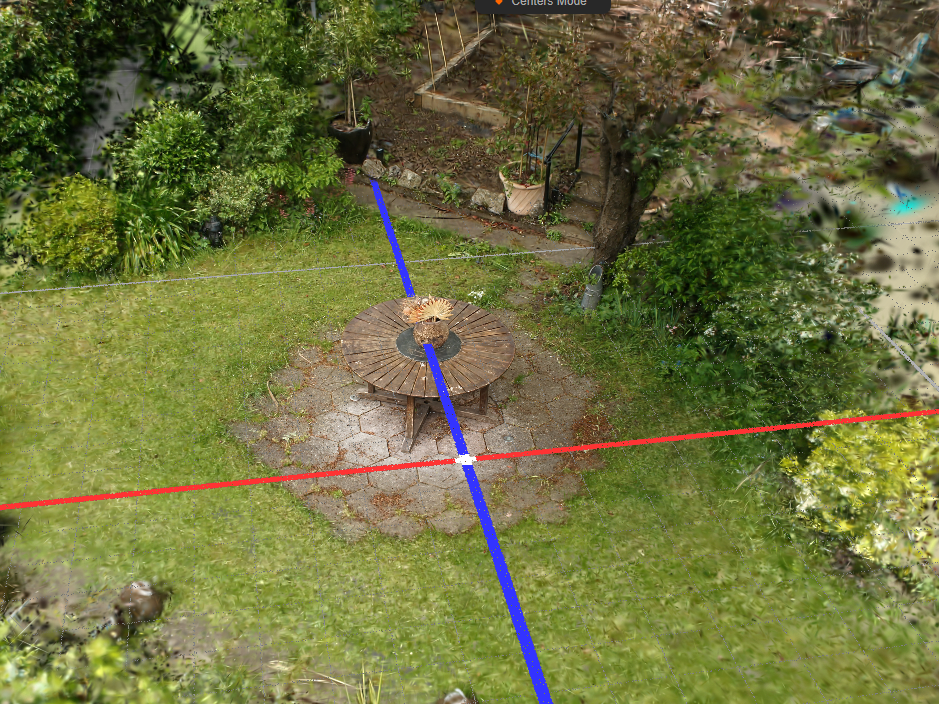

## Step 9: Access and Render the Generated Point Cloud

After training, the reconstructed scene is exported as a point cloud in **PLY** format.  

- The generated file is **always named `anchor_0.ply`**, regardless of the model or scene.  
- It is located in the `point_clouds` subfolder of your model output directory:  

/content/results/model_name/point_clouds/anchor_0.ply


- If you train other models or on different scenes, look inside the corresponding `point_clouds` folder for the `anchor_0.ply` file.  
- This file can be rendered easily in a web viewer such as [SuperSpl.at Editor](https://superspl.at/editor/).

Below, you can download the `.ply` file from Colab to your local machine for visualization.



In [ ]:
### Download the .ply file to render for example in https://superspl.at/editor/
from google.colab import files

# Path to the generated PLY file
ply_path = "/content/results/MipNeRF360/garden/point_clouds/anchor_0.ply"

# Download to your local machine
files.download(ply_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 10: Prepare a Custom Dataset for Training

If you want to train the model on your own images, you can create a new folder (e.g., `Sculpture`) inside `/content/Images` and drag & drop your image files there.  

**Important:** The training script expects images to be inside an `images` subfolder.  
The code below automatically creates this subfolder and moves all `.png`, `.jpg`, or `.jpeg` files into it, so the dataset is ready for training.


In [ ]:
import os
import shutil
from pathlib import Path

# Set your dataset folder here
dataset_path = Path("/content/Images/Sculpture")

# Create 'images' subfolder if it doesn't exist
images_subfolder = dataset_path / "images"
images_subfolder.mkdir(exist_ok=True)

# Move image files into 'images' subfolder
for ext in ("*.png", "*.jpg", "*.jpeg"):
    for img_file in dataset_path.glob(ext):
        shutil.move(str(img_file), str(images_subfolder / img_file.name))

print(f"Dataset folder '{dataset_path}' is now ready with {len(list(images_subfolder.glob('*')))} images in 'images/'")


Dataset folder '/content/Images/Sculpture' is now ready with 20 images in 'images/'


In [ ]:
### Train the model
!python train.py -s /content/Images/Sculpture -m /content/results/Sculpture --test_hold 8 --test_frequency 20

Provide model format: '.bin' or '.txt'
Initializing modules and running just in time compilation, may take a while...
Using cache found in /root/.cache/torch/hub/verlab_accelerated_features_main
Compiling feature extractor
Using cache found in /root/.cache/torch/hub/verlab_accelerated_features_main
Starting reconstruction for /content/Images/Sculpture
100% 20/20 [00:21<00:00,  1.06s/it, Focal:1055.7,Keyframes:16,Gaussians:521315,Anchors:1]
Saving the reconstruction to: /content/results/Sculpture
num anchors: 1, num keyframes: 16, time: 21.149, FPS: 0.946, PSNR: 22.399, SSIM: 0.792, LPIPS: 0.284


In [ ]:
### Download the .ply file to render for example in https://superspl.at/editor/
from google.colab import files

# Path to the generated PLY file
ply_path = "/content/results/Sculpture/point_clouds/anchor_0.ply"  ### check this may be incorrect

# Download to your local machine
files.download(ply_path)

## Rendered model

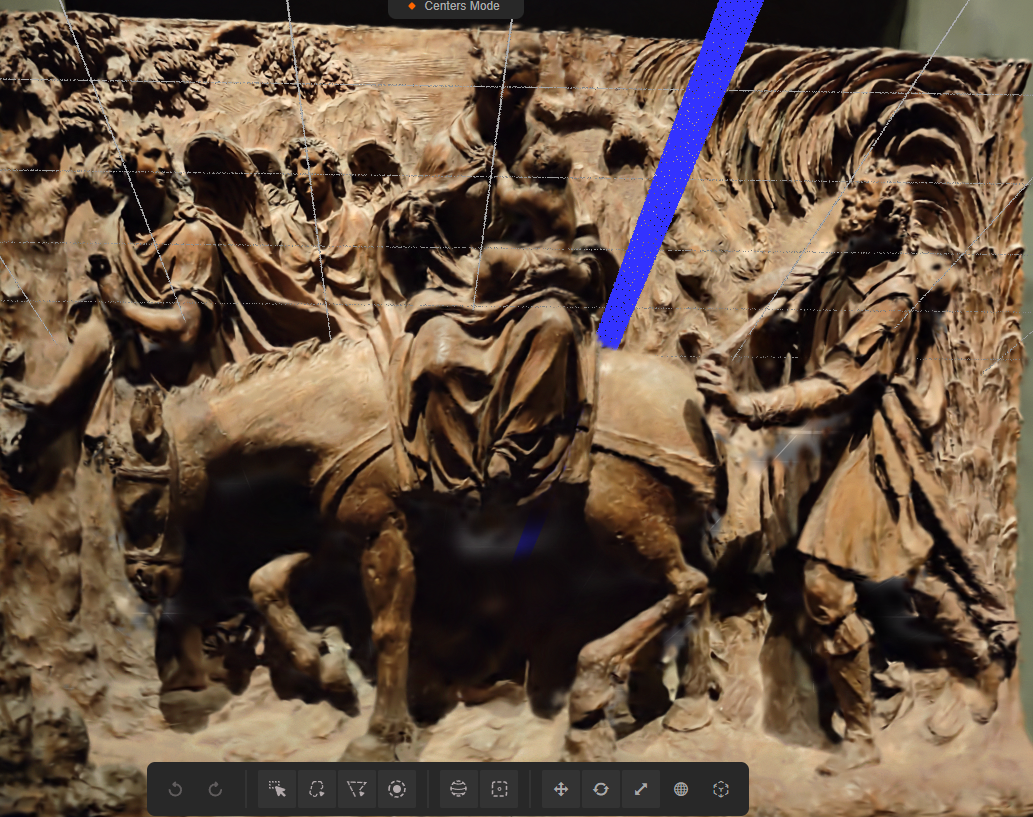